In [1]:
import pandas as pd
import numpy as np
import datetime as dt


import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from category_encoders import OneHotEncoder


# Import Data

In [2]:
def wrangle(file_path):
    # Load the csv file
    data = pd.read_csv(file_path)

    # Create a lit of columns to drop because of high missing values
    drop_cols = ["call_type", "call_status", "start_time", "duration", "end_time", "display_location", "cost_zar"]

    # Adding high and low cardinality features
    drop_cols.append("ad_type")

    # Convert the currency to ZAR and compute the cost in ZAR since 94 % of the database is in ZAR currency
    data["cost_zar"] = data.apply(lambda row : row["cost"] * 19.18 if row["currency"] == "USD" else row["cost"], axis=1)

    # Dropping the rows where the currency is not known
    data = data[~data["currency"].isnull()]

    # Adding to the drop list the cost and currency columns
    drop_cols.extend(["cost", "currency"])

    # Handle multicolinearity features
    drop_cols.extend(["headline1_len", "ad_description_len", "headline2_len", "conversions"])
    
    # Converting the data column to data type
    data["date"] = pd.to_datetime(data["date"])
     
    # Drop the columns selected above
    data = data.drop(columns=drop_cols)
    
    # Aggregating by date
    data = data.groupby(["ID", "date"]).sum()
    
    # Creating lag
    data["clicks_lag"] = data["clicks"].shift(1)
    data.dropna(inplace=True)
    

    return data

In [3]:
df = wrangle("Data/Train.csv")
df.head()

impressions  clicks  impression_share  \
ID                          date                                                
ID_5da86e71bf5dee4cf5047046 2020-01-02        395.0    50.0         97.362532   
                            2020-01-03        404.0    54.0        125.369703   
                            2020-01-04        476.0    47.0        126.616261   
                            2020-01-05        466.0    59.0        143.848584   
                            2020-01-06        492.0    60.0        141.717073   

                                        conversions_calls  clicks_lag  
ID                          date                                       
ID_5da86e71bf5dee4cf5047046 2020-01-02                0.0        36.0  
                            2020-01-03                0.0        50.0  
                            2020-01-04                0.0        54.0  
                            2020-01-05                0.0        47.0  
                            2020-01-06                0.0        59.0

# Exploratory Data Analysis

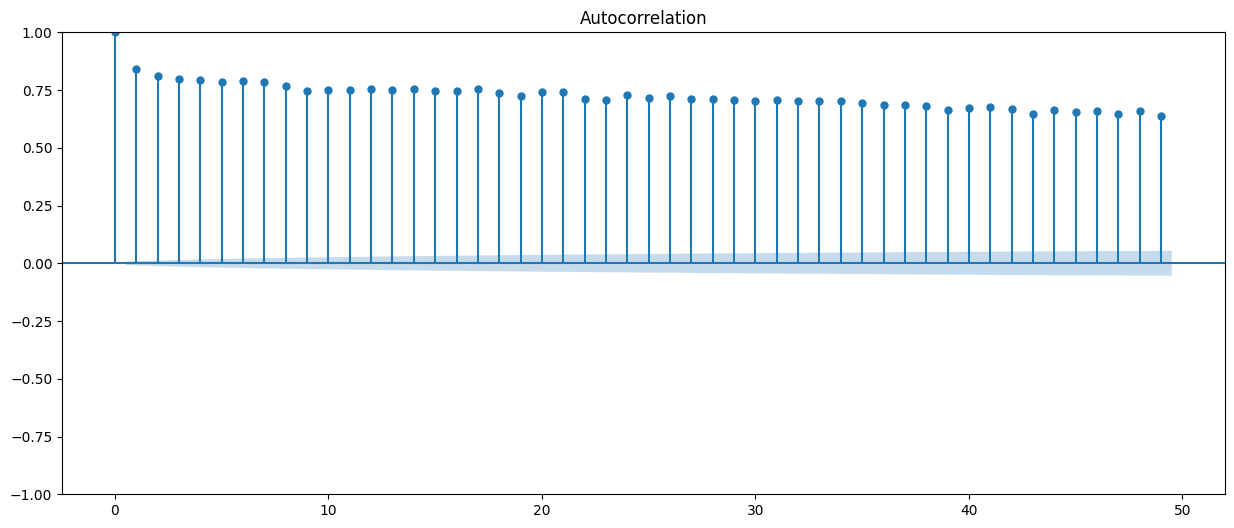

In [70]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df["clicks"], ax=ax);


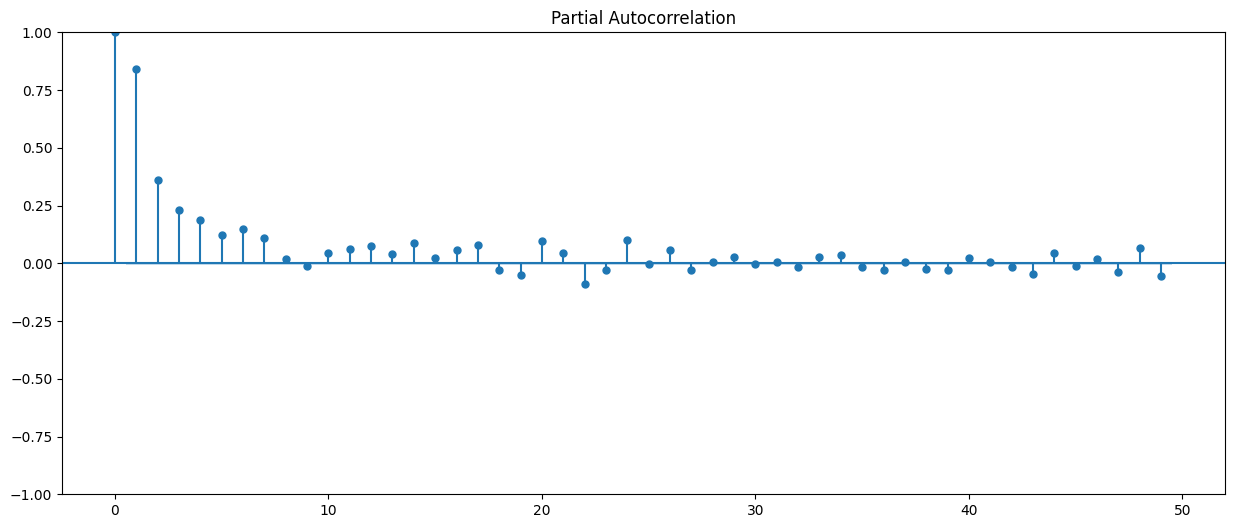

In [69]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(df["clicks"], ax=ax);

In [ ]:
df[["cost_zar", "headline1_len", "clicks"]].corr().style.background_gradient()

,cost_zar,headline1_len,clicks
cost_zar,1.000000,0.554749,0.579259
headline1_len,0.554749,1.000000,0.086655
clicks,0.579259,0.086655,1.000000


In [ ]:
df[["cost_zar", "ad_description_len", "clicks"]].corr().style.background_gradient()

,cost_zar,ad_description_len,clicks
cost_zar,1.000000,-0.647138,0.579259
ad_description_len,-0.647138,1.000000,-0.202437
clicks,0.579259,-0.202437,1.000000


In [79]:
df.corr().style.background_gradient()

,impressions,clicks,impression_share,conversions_calls,clicks_lag
impressions,1.000000,0.794699,0.285159,0.418822,0.576322
clicks,0.794699,1.000000,0.260557,0.271360,0.839256
impression_share,0.285159,0.260557,1.000000,0.397182,0.184260
conversions_calls,0.418822,0.271360,0.397182,1.000000,0.108916
clicks_lag,0.576322,0.839256,0.184260,0.108916,1.000000


## Spliting the database

In [80]:
index_frame = df.index.to_frame().reset_index(drop=True)

date_range = index_frame["date"].max() - index_frame["date"].min()
date_range

Timedelta('1503 days 00:00:00')

In [81]:
cutt_off = 1504 * 0.8
cutt_off

1203.2

In [82]:
start_date, end_date = index_frame["date"].min(), index_frame["date"].min() + dt.timedelta(cutt_off)

### Features matrix and target vector

In [154]:

df.index.get_level_values("ID").nunique()

159

In [83]:
target = "clicks"
X = df.drop(columns=target) # Features matrix
y = df[target] # target vector
X.shape, y.shape

((67567, 4), (67567,))

### Train and test data

In [84]:
mask_1, mask_2 = df.index.get_level_values("date") >= start_date, df.index.get_level_values("date") < end_date # For training set
mask_3 = df.index.get_level_values("date") >= end_date

X_train, y_train = X[mask_1 & mask_2], y[mask_1 & mask_2]
X_test, y_test = X[mask_3], y[mask_3]

# Model

## Baseline

In [85]:
y_pred_baseline = [y_train.mean() for i in range(len(y_train))]
baseline_mse = mean_squared_error(y_train, y_pred_baseline)
baseline_mse

11439.408946369702

## Iterate

In [86]:
model = make_pipeline(
    SimpleImputer(),
    Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [87]:
test_mse = mean_squared_error(y_test, model.predict(X_test))
test_mse

5226.754374100665

In [90]:
y_pred = pd.Series(model.predict(X_test).astype(int), index=X_test.index)
y_pred

ID                           date      
ID_5da86e71bf5dee4cf5047046  2023-04-20     98
                             2023-04-21     81
                             2023-04-22     84
                             2023-04-23     84
                             2023-04-24     77
                                          ... 
ID_65b0f65c7fe62e56c5593d55  2024-02-09     66
                             2024-02-10     70
                             2024-02-11    143
                             2024-02-12    120
                             2024-02-13    109
Length: 29891, dtype: int32

In [91]:
y_test

ID                           date      
ID_5da86e71bf5dee4cf5047046  2023-04-20    64.0
                             2023-04-21    68.0
                             2023-04-22    76.0
                             2023-04-23    68.0
                             2023-04-24    67.0
                                           ... 
ID_65b0f65c7fe62e56c5593d55  2024-02-09    37.0
                             2024-02-10    55.0
                             2024-02-11    94.0
                             2024-02-12    78.0
                             2024-02-13    74.0
Name: clicks, Length: 29891, dtype: float64

In [88]:
model_1 = RandomForestRegressor()
model_1.fit(X_train, y_train)

RandomForestRegressor()

In [89]:
t_mse = mean_squared_error(y_test, model_1.predict(X_test))
t_mse

2991.5157091159754